In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from variational_lse_solver import VarLSESolver

from device_var_lse_solver import DeviceVarLSESolver
from non_dynamical_ansatz import fixed_layered_ansatz
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator
from conditioned_matrix import create_conditioned_random_matrix


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

'\nTo run this script you need the following packages:\n- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)\n- Numpy < 2: need to install something like numpy 1.26.4\n- Python 3.12\n- torch 2.2.2\n'

In [3]:
# unitary representation of Paulis
I_ = np.array([[1.0, 0.0], [0.0, 1.0]])
X_ = np.array([[0.0, 1.0], [1.0, 0.0]])
Y_ = np.array([[0.0, -1.j], [1.j, 0.0]])
Z_ = np.array([[1.0, 0.0], [0.0, -1.0]])

a = ["III", "XZI", "XII"]
b = np.ones(8)/np.sqrt(8)

qubits = 3
device = Device(DeviceType.QISKIT_AER, qubits=qubits)


## Comparing dynamic circuit and non-dynamical circuit
Here we will compare the performance of the dynamical circuit and the non-dynamical circuit. We will evaluate the performance on both speed and accuracy, and the results are averaged over N runs. 

We will first solve the problem with the dynamical circuit, and thereafter let the fixed circuit perform the same computation with $d=max(d_{dyn})$. 

## Comparison of noisy static local, noisy dynamic local, noisy static global and noisy dynamic global

In [4]:
N_runs = 1
N_steps = 50
max_epoch_dyn = 10
threshold = 0.001

n_qubits = 3
depth = 10
param_shape = (n_qubits + depth*(n_qubits+n_qubits-2),)

results_dyn_local = np.zeros([N_runs, len(b)])
results_dyn_global = np.zeros([N_runs, len(b)])

results_stat_local = np.zeros([N_runs, len(b)])
results_stat_global = np.zeros([N_runs, len(b)])

for i in range(N_runs):
    lse_dyn_local = DeviceVarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=True, 
                lr=0.1, 
                threshold=threshold,
                steps=N_steps,
                epochs=max_epoch_dyn, 
                device=device) 
    
    solution_dyn_local, _ = lse_dyn_local.solve()
    results_dyn_local[i,:] = solution_dyn_local


    lse_dyn_global = DeviceVarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=False, 
                lr=0.1, 
                threshold=threshold,
                steps=N_steps,
                epochs=max_epoch_dyn, 
                device=device) 
    
    solution_dyn_global, _ = lse_dyn_global.solve()
    results_dyn_global[i,:] = solution_dyn_global

for i in range(N_runs):
    lse_stat_local = DeviceVarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                ansatz=fixed_layered_ansatz,
                weights=param_shape,
                local=True, 
                lr=0.1, 
                threshold=threshold,
                steps=N_steps,
                device=device) 
    
    solution_stat_local, _ = lse_stat_local.solve()
    results_stat_local[i,:] = solution_stat_local


    lse_stat_global = DeviceVarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                ansatz=fixed_layered_ansatz,
                weights=param_shape,
                local=False, 
                lr=0.1, 
                threshold=threshold,
                steps=N_steps,
                device=device) 
    
    solution_stat_global, _ = lse_stat_global.solve()
    results_stat_global[i,:] = solution_stat_global

Epoch 1/10: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s, best loss=0.00241, last improvement in step=49, loss=0.00241]
Increasing circuit depth.
Epoch 2/10: 100%|██████████| 50/50 [00:03<00:00, 15.60it/s, best loss=0.00163, last improvement in step=45, loss=0.00244]
Increasing circuit depth.
Epoch 3/10: 100%|██████████| 50/50 [00:03<00:00, 14.99it/s, best loss=0.00138, last improvement in step=46, loss=0.00169]
Increasing circuit depth.
Epoch 4/10:  88%|████████▊ | 44/50 [00:03<00:00, 13.19it/s, best loss=0.00131, last improvement in step=40, loss=0.00137]
Loss of 0.0009151745 below stopping threshold.
Returning solution.
Epoch 1/10: 100%|██████████| 50/50 [00:01<00:00, 28.83it/s, best loss=0.00239, last improvement in step=43, loss=0.00352]
Increasing circuit depth.
Epoch 2/10: 100%|██████████| 50/50 [00:01<00:00, 25.99it/s, best loss=0.0129, last improvement in step=49, loss=0.0129]
Increasing circuit depth.
Epoch 3/10: 100%|██████████| 50/50 [00:01<00:00, 27.75it/s, best loss=0.0

In [5]:
A = 1.0 * np.kron(I_, np.kron(I_, I_)) + 0.2 * np.kron(X_, np.kron(Z_, I_)) + 0.2 * np.kron(X_, np.kron(I_, I_))
classical_solution = np.linalg.solve(A, b)
normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))


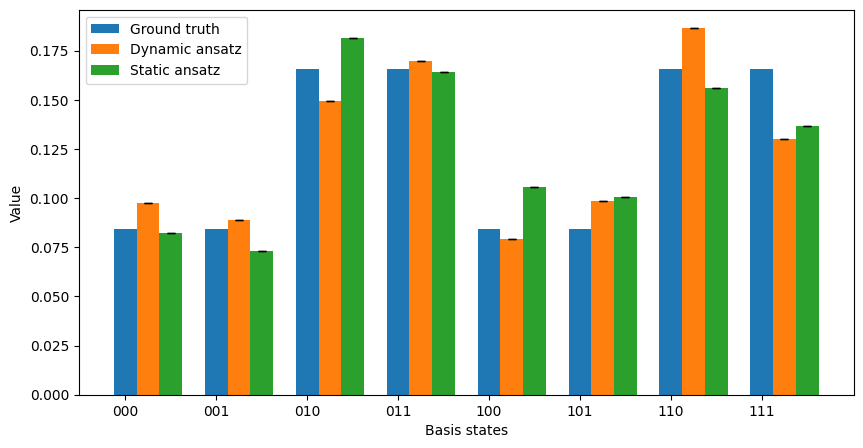

In [6]:
plt.figure(figsize=(10, 5))

x = np.arange(len(normalized_classical_solution)) 
width = 0.25 
multiplier = 0

plt.bar(x, normalized_classical_solution, width = width, label='Ground truth')
plt.bar(x + width, np.mean(results_dyn_local, axis=0), yerr=np.std(results_dyn_local,axis=0)/np.sqrt(len(results_dyn_local)), width=width, capsize=3, label='Dynamic ansatz')
plt.bar(x + 2*width, np.mean(results_stat_local, axis=0), yerr=np.std(results_stat_local, axis=0)/np.sqrt(len(results_stat_local)), width=width, capsize=3, label='Static ansatz')

plt.legend()
plt.xticks(x, ['000', '001', '010', '011', '100', '101', '110', '111'])
plt.xlabel('Basis states')
plt.ylabel('Value')
plt.show()

### Graph Laplacian


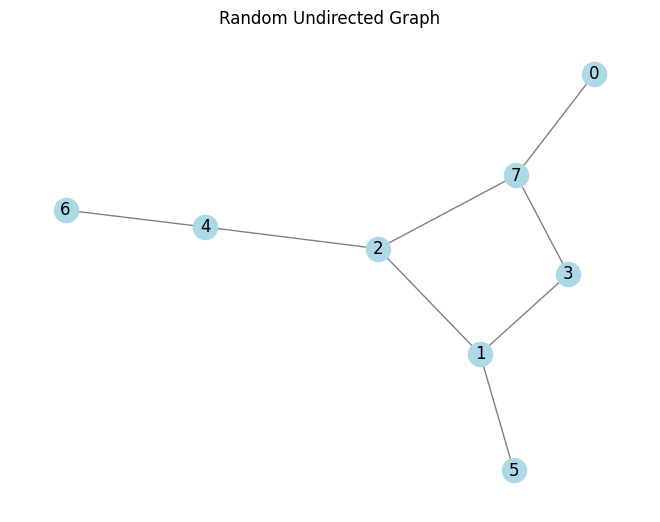

Adjacency matrix A:
 [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]]

Degree matrix D:
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3.]]

Graph Laplacian L = D - A:
 [[ 1.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  3. -1. -1.  0. -1.  0.  0.]
 [ 0. -1.  3.  0. -1.  0.  0. -1.]
 [ 0. -1.  0.  2.  0.  0.  0. -1.]
 [ 0.  0. -1.  0.  2.  0. -1.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [-1.  0. -1. -1.  0.  0.  0.  3.]]


In [20]:
import networkx as nx

n_nodes = 8  # for 3 qubits, we have 2^3 = 8 nodes
edge_prob = 0.5  # Probability for edge creation

# Step 1: Generate a random undirected graph (Erdős–Rényi model)
G = nx.erdos_renyi_graph(n=n_nodes, p=edge_prob)

# Step 2: Compute the adjacency matrix A
A = nx.to_numpy_array(G)

# Step 3: Compute the degree matrix D
D = np.diag(A.sum(axis=1))

# Step 4: Compute the unnormalized Laplacian L = D - A
L = D - A

# Step 5 (optional): Visualize the graph and the matrix
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Random Undirected Graph")
plt.show()

print("Adjacency matrix A:\n", A)
print("\nDegree matrix D:\n", D)
print("\nGraph Laplacian L = D - A:\n", L)

b = np.ones(8)/np.sqrt(8)  # Initialize b as a uniform distribution over the basis states


In [21]:
N_steps = 50
max_epoch_dyn = 10
threshold = 0.0001

n_qubits = 3
depth = 10
param_shape = (n_qubits + depth*(n_qubits+n_qubits-2),)

results_dyn_local = np.zeros([N_runs, len(b)])
results_dyn_global = np.zeros([N_runs, len(b)])

results_stat_local = np.zeros([N_runs, len(b)])
results_stat_global = np.zeros([N_runs, len(b)])


lse_dyn_local = DeviceVarLSESolver(A, 
            b, 
            #coeffs=[1.0, 0.2, 0.2], # Used for the Hadamard method
            method="direct", 
            local=True, 
            lr=0.1, 
            threshold=threshold,
            steps=N_steps,
            epochs=max_epoch_dyn, 
            device=device) 

solution_dyn_local, _ = lse_dyn_local.solve()
results_dyn_local[i,:] = solution_dyn_local




Epoch 1/10: 100%|██████████| 50/50 [00:00<00:00, 272.08it/s, best loss=0.0881, last improvement in step=49, loss=0.0881]
Increasing circuit depth.
Epoch 2/10: 100%|██████████| 50/50 [00:00<00:00, 167.82it/s, best loss=0.0803, last improvement in step=49, loss=0.0803]
Increasing circuit depth.
Epoch 3/10: 100%|██████████| 50/50 [00:00<00:00, 122.08it/s, best loss=0.0784, last improvement in step=49, loss=0.0784]
Increasing circuit depth.
Epoch 4/10: 100%|██████████| 50/50 [00:00<00:00, 85.67it/s, best loss=0.0774, last improvement in step=48, loss=0.0775]
Increasing circuit depth.
Epoch 5/10: 100%|██████████| 50/50 [00:00<00:00, 75.52it/s, best loss=0.0773, last improvement in step=49, loss=0.0773]
Increasing circuit depth.
Epoch 6/10: 100%|██████████| 50/50 [00:00<00:00, 63.69it/s, best loss=0.0774, last improvement in step=42, loss=0.0774]
Increasing circuit depth.
Epoch 7/10: 100%|██████████| 50/50 [00:00<00:00, 54.92it/s, best loss=0.0773, last improvement in step=43, loss=0.0773]
I

In [22]:
epsilon = 1e-3
L_reg = L + epsilon * np.eye(n_nodes)
classical_solution = np.linalg.solve(L_reg, b)
normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))


In [23]:
# print and compare solutions
print('\nNoisy Local Quantum:\n|', end='')
for s in solution_dyn_local:
    print(f' {s:.4f} |', end='')
print('\nClassical:\n|', end='')
for s in normalized_classical_solution:
    print(f' {np.abs(s):.4f} |', end='')
print()


Noisy Local Quantum:
| 0.0059 | 0.1113 | 0.2119 | 0.0430 | 0.2227 | 0.0098 | 0.0127 | 0.3828 |
Classical:
| 0.1250 | 0.1250 | 0.1250 | 0.1250 | 0.1250 | 0.1250 | 0.1250 | 0.1250 |
